# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Initialize settings (reads from .env when available, otherwise from environment variables)
from mlfs import config
env_file = f"{root_dir}/.env" if os.path.exists(f"{root_dir}/.env") else None
settings = config.HopsworksSettings(_env_file=env_file)

Local environment
Added the following directory to the PYTHONPATH: /Users/datskiw/KTH/ID2223/labs/mlfs-book
HopsworksSettings initialized!


In [2]:
import datetime
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util

## <span style='color:#ff5f27'> ⚙️ PARAMETERS - Sensor Configuration</span>

This notebook is parameterized to work with different sensors. Set these values in your `.env` file or as environment variables:

- `AQICN_COUNTRY`: Country name (e.g., "sweden")
- `AQICN_CITY`: City name (e.g., "stockholm")
- `AQICN_STREET`: Street/sensor identifier - this is the unique identifier for each sensor (e.g., "st-eriksgatan-83")

**Note:** This notebook will retrieve the sensor-specific model and make predictions for the configured sensor.


In [3]:
# Location parameters - read from .env via settings
# Note: 'street' is the unique identifier for each sensor
country = settings.AQICN_COUNTRY
city = settings.AQICN_CITY
street = settings.AQICN_STREET

print(f"Making predictions for sensor: {street}")
print(f"Location: {country}, {city}, {street}")


Making predictions for sensor: asane
Location: norway, bergen, asane


In [4]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 18, 11, 53, 28, 700288)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [5]:
# The HOPSWORKS_API_KEY is automatically set by the settings object (see mlfs/config.py)
# Location parameters are already read from settings in Cell 5 above
project = hopsworks.login()
fs = project.get_feature_store()

2025-11-18 11:53:28,714 INFO: Initializing external client
2025-11-18 11:53:28,714 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-18 11:53:29,382 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-18 11:53:30,292 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286300


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [6]:
mr = project.get_model_registry()

# Retrieve the sensor-specific model
# Replace hyphens with underscores in street name (model names match [a-zA-Z0-9_]+)
street_safe = street.replace('-', '_')
model_name = f"air_quality_xgboost_model_{street_safe}"
print(f"Retrieving model: {model_name}")

# Get the latest version of the model for this sensor
retrieved_model = mr.get_model(
    name=model_name,
    version=None,  # Get the latest version
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Retrieving model: air_quality_xgboost_model_asane
2025-11-18 11:53:31,535 WARNING: VersionWarning: No version provided for getting model `air_quality_xgboost_model_asane`, defaulting to `1`.

2025-11-18 11:53:34,843 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/467603 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/123528 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/21343 elapsed<00:00 remaining<?

In [7]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='1.647245E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [8]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
# Filter weather data by city and date to avoid duplicates
batch_data = weather_fg.filter(
    (weather_fg.date >= today) & 
    (weather_fg.city == city)
).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.66s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-23 00:00:00+00:00,5.70,0.3,16.583460,152.878784,bergen
1,2025-11-24 00:00:00+00:00,2.85,0.0,7.695920,100.784256,bergen
2,2025-11-20 00:00:00+00:00,-0.85,0.0,1.138420,341.564941,bergen
3,2025-11-21 00:00:00+00:00,0.70,0.7,6.830519,161.564957,bergen
4,2025-11-22 00:00:00+00:00,3.95,0.1,9.885262,123.111351,bergen
5,2025-11-19 00:00:00+00:00,-0.90,0.0,3.877318,68.198532,bergen


In [9]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
dtypes: datetime64[us, Etc/UTC](1), float32(4), object(1)
memory usage: 320.0+ bytes


In [10]:
# Retrieve the latest 3 air quality records for this sensor (sorted by date descending)
air_fg = fs.get_feature_group(
    name='air_quality',
    version=10,
)

# Filter by this specific sensor
air_quality_df = air_fg.filter(
    (air_fg.country == country) & 
    (air_fg.city == city) & 
    (air_fg.street == street)
).read()

air_quality_recent = air_quality_df.sort_values("date", ascending=False).head(3)
air_quality_recent

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.96s) 


,date,pm25,country,city,street,url,pm25_rolling_3d_mean
1215,2025-11-18 00:00:00+00:00,18.0,norway,bergen,asane,https://api.waqi.info/feed/@12710,14.000000
198,2025-11-17 00:00:00+00:00,12.0,norway,bergen,asane,https://api.waqi.info/feed/@12710,15.333333
1121,2025-11-16 00:00:00+00:00,11.0,norway,bergen,asane,https://api.waqi.info/feed/@12710,14.000000


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [11]:
# Autoregressive multi-day PM2.5 forecast using the latest 3 values (historical or inferred)

# Ensure forecast weather data is sorted by date
batch_data = batch_data.sort_values("date", ascending=True).copy()

# Initialize the last 3 pm25 values from the most recent historical data
# (we sort ascending so the last 3 entries are the latest in time)
last_three_pm25 = list(air_quality_recent.sort_values("date", ascending=True)["pm25"].values)

predictions = []
rolling_means = []

for _, row in batch_data.iterrows():
    # Use the mean of the last 3 pm25 values as in training (pm25_rolling_3d_mean)
    pm25_rolling_3d_mean = float(np.mean(last_three_pm25))
    rolling_means.append(pm25_rolling_3d_mean)

    features = pd.DataFrame({
        "pm25_rolling_3d_mean": [pm25_rolling_3d_mean],
        "temperature_2m_mean": [row["temperature_2m_mean"]],
        "precipitation_sum": [row["precipitation_sum"]],
        "wind_speed_10m_max": [row["wind_speed_10m_max"]],
        "wind_direction_10m_dominant": [row["wind_direction_10m_dominant"]],
    })

    # Predict next day's pm25
    pm25_pred = float(retrieved_xgboost_model.predict(features)[0])
    predictions.append(pm25_pred)

    # Update the list of last 3 pm25 values with the new prediction (autoregressive)
    last_three_pm25.append(pm25_pred)
    if len(last_three_pm25) > 3:
        last_three_pm25.pop(0)

# Attach predictions and rolling feature to batch_data for downstream plotting and monitoring
batch_data["pm25_rolling_3d_mean"] = np.array(rolling_means, dtype="float32")
batch_data["predicted_pm25"] = np.array(predictions, dtype="float32")
batch_data


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_rolling_3d_mean,predicted_pm25
5,2025-11-19 00:00:00+00:00,-0.90,0.0,3.877318,68.198532,bergen,13.666667,23.716778
2,2025-11-20 00:00:00+00:00,-0.85,0.0,1.138420,341.564941,bergen,17.905592,14.822681
3,2025-11-21 00:00:00+00:00,0.70,0.7,6.830519,161.564957,bergen,18.846487,23.139687
4,2025-11-22 00:00:00+00:00,3.95,0.1,9.885262,123.111351,bergen,20.559715,10.850924
0,2025-11-23 00:00:00+00:00,5.70,0.3,16.583460,152.878784,bergen,16.271097,13.167078
1,2025-11-24 00:00:00+00:00,2.85,0.0,7.695920,100.784256,bergen,15.719230,16.167925


In [12]:
# batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
#     batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
# batch_data

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [13]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Remove any duplicate dates before adding days_before_forecast_day
# (duplicates can occur if weather data has multiple entries per date)
batch_data = batch_data.drop_duplicates(subset=['date'], keep='first')
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_rolling_3d_mean,predicted_pm25,street,country,days_before_forecast_day
5,2025-11-19 00:00:00+00:00,-0.90,0.0,3.877318,68.198532,bergen,13.666667,23.716778,asane,norway,1
2,2025-11-20 00:00:00+00:00,-0.85,0.0,1.138420,341.564941,bergen,17.905592,14.822681,asane,norway,2
3,2025-11-21 00:00:00+00:00,0.70,0.7,6.830519,161.564957,bergen,18.846487,23.139687,asane,norway,3
4,2025-11-22 00:00:00+00:00,3.95,0.1,9.885262,123.111351,bergen,20.559715,10.850924,asane,norway,4
0,2025-11-23 00:00:00+00:00,5.70,0.3,16.583460,152.878784,bergen,16.271097,13.167078,asane,norway,5
1,2025-11-24 00:00:00+00:00,2.85,0.0,7.695920,100.784256,bergen,15.719230,16.167925,asane,norway,6


In [14]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 5 to 1
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   pm25_rolling_3d_mean         6 non-null      float32                
 7   predicted_pm25               6 non-null      float32                
 8   street                       6 non-null      object                 
 9   country                      6 non-null      object                 
 10  days_before

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2025-11-18 11:53:43,783 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



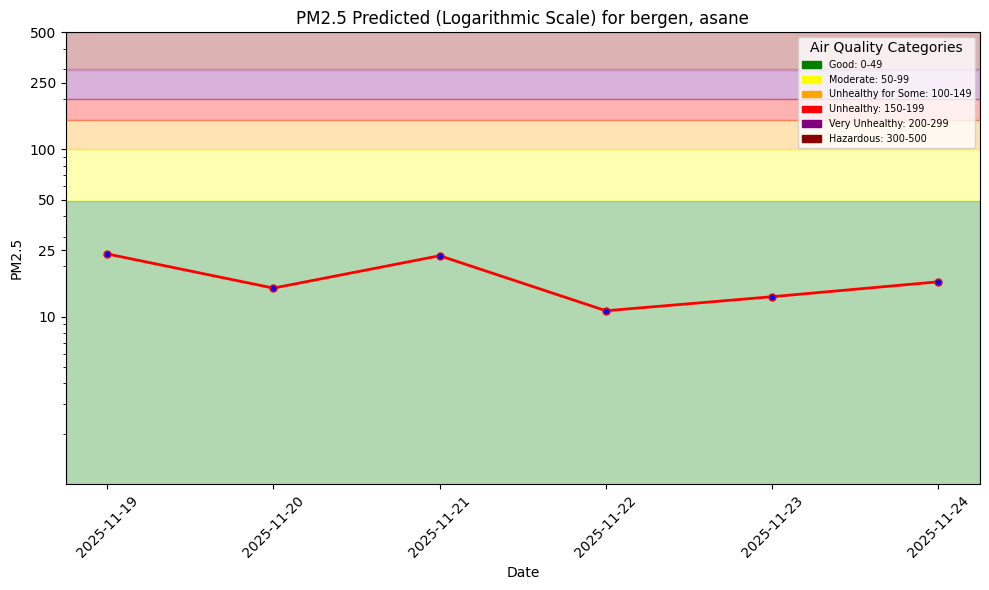

In [15]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [16]:
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=10,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [17]:
monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_10_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286300/jobs/named/aq_predictions_10_offline_fg_materialization/executions
2025-11-18 11:54:01,967 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 11:54:05,169 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 11:55:38,011 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 11:55:38,177 INFO: Waiting for log aggregation to finish.
2025-11-18 11:55:50,136 INFO: Execution finished successfully.


(Job('aq_predictions_10_offline_fg_materialization', 'SPARK'), None)

In [18]:
# We will create a hindcast chart for only the forecasts made 1 day beforehand
# Filter by sensor and days_before_forecast_day
monitoring_df = monitor_fg.filter(
    (monitor_fg.city == city) & 
    (monitor_fg.street == street) & 
    (monitor_fg.days_before_forecast_day == 1)
).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.03s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_rolling_3d_mean,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-19 00:00:00+00:00,-0.9,0.0,3.877318,68.198532,bergen,13.666667,23.716778,asane,norway,1


In [19]:
# Retrieve air quality data for this sensor
air_quality_fg = fs.get_feature_group(name='air_quality', version=10)
air_quality_df = air_quality_fg.filter(
    (air_quality_fg.country == country) & 
    (air_quality_fg.city == city) & 
    (air_quality_fg.street == street)
).read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.95s) 


,date,pm25,country,city,street,url,pm25_rolling_3d_mean
0,2022-06-11 00:00:00+00:00,38.0,norway,bergen,asane,https://api.waqi.info/feed/@12710,29.666666
1,2022-01-28 00:00:00+00:00,12.0,norway,bergen,asane,https://api.waqi.info/feed/@12710,25.333334
2,2022-09-02 00:00:00+00:00,8.0,norway,bergen,asane,https://api.waqi.info/feed/@12710,17.000000
3,2021-01-16 00:00:00+00:00,16.0,norway,bergen,asane,https://api.waqi.info/feed/@12710,20.000000
4,2024-10-30 00:00:00+00:00,37.0,norway,bergen,asane,https://api.waqi.info/feed/@12710,14.666667
...,...,...,...,...,...,...,...
1903,2025-08-29 00:00:00+00:00,14.0,norway,bergen,asane,https://api.waqi.info/feed/@12710,18.333334
1904,2025-10-21 00:00:00+00:00,5.0,norway,bergen,asane,https://api.waqi.info/feed/@12710,6.333333
1905,2024-05-19 00:00:00+00:00,23.0,norway,bergen,asane,https://api.waqi.info/feed/@12710,24.000000
1906,2024-08-17 00:00:00+00:00,30.0,norway,bergen,asane,https://api.waqi.info/feed/@12710,16.333334


In [20]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.94s) 


Uploading Dataframe: 100.00% |██████████| Rows 4/4 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_10_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286300/jobs/named/aq_predictions_10_offline_fg_materialization/executions
2025-11-18 11:56:12,851 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 11:56:16,059 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 11:57:45,933 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 11:57:46,099 INFO: Waiting for log aggregation to finish.
2025-11-18 11:57:54,896 INFO: Execution finished successfully.


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_rolling_3d_mean,predicted_pm25,pm25,street,country,days_before_forecast_day
0,2025-11-15 00:00:00+00:00,0.421083,2.000000,13.080688,140.738266,bergen,12.333333,7.755713,19.0,asane,norway,1
1,2025-11-16 00:00:00+00:00,2.321083,7.599999,18.279530,331.019012,bergen,14.000000,10.411343,11.0,asane,norway,1
2,2025-11-17 00:00:00+00:00,1.433583,3.300000,20.423456,337.764252,bergen,15.333333,11.020021,12.0,asane,norway,1
3,2025-11-18 00:00:00+00:00,0.900000,0.100000,2.545584,44.999897,bergen,14.000000,13.213991,18.0,asane,norway,1


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

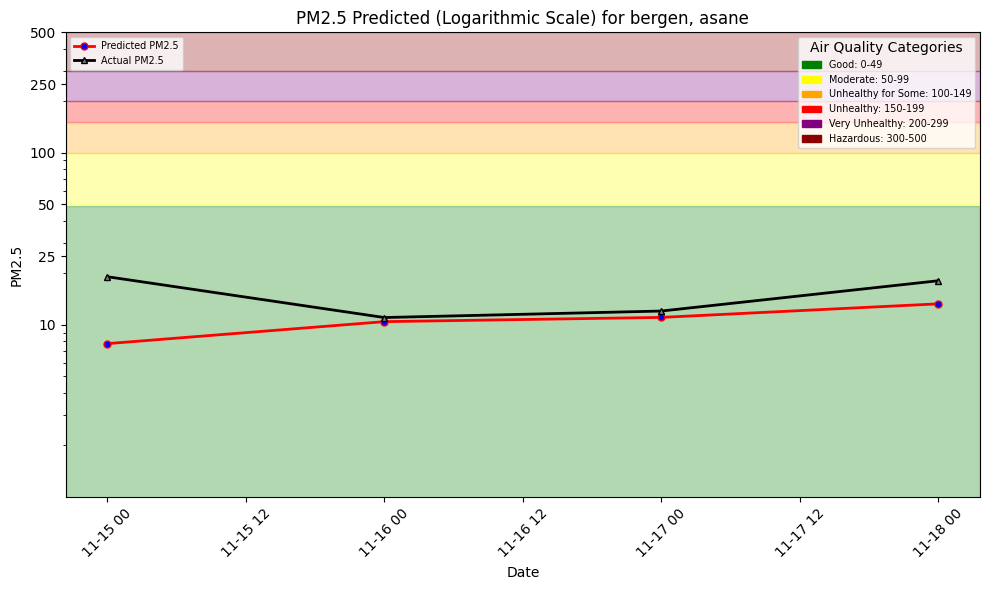

In [21]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [22]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /Users/datskiw/KTH/ID2223/labs/mlfs-book/docs/air-quality/assets/img/pm25_forecast.png: 0.000%|     …

Uploading /Users/datskiw/KTH/ID2223/labs/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day.png: 0.000%|…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286300/settings/fb/path/Resources/airquality


---